## Demo 4: Markov chain Monte Carlo

Today, we will develop some intuition about Markov chain Monte Carlo methods and sample from some distribution. We will introduce MCMC fundamentals and then focus on how the Metropolis–Hastings algorithm work in a toy example. Supplementary sections include how we can generate, store, and save MCMC results.

### Goals:
1. Understand Markov chain Monte Carlo fundamentals
2. Recognize the meaning of sample, draws, and chains in MCMC context

### Notes:
* This DEMO is based on Ravin Kumar's [tutorial](https://github.com/canyon289/bayesian-model-evaluation) at Scipy Conference 2019, especially [Section 2.1](https://github.com/canyon289/bayesian-model-evaluation/blob/master/notebooks/2_DataStructures/1_Ins_DataStructures.ipynb).
* Check out [Section 3](https://github.com/canyon289/bayesian-model-evaluation/tree/master/notebooks/3_SinglePlotDiagnostics) of the same tutorial to see how we can determine that our Markov Chain Monte Carlo inference run has converged.
* Check out this [Richard McElreath blog](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/) for a great visual explainer of other flavors of MC moves (e.g., Hamiltonian Monte Carlo or the No U-Turn Sampler).
* Related MCMC ideas: burn-in steps, simulated annealing, etc.



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import stan
import xarray as xr
from IPython.display import Video

np.random.seed(0)
plt.style.use('arviz-white')

import warnings
warnings.filterwarnings('ignore')

# To use PyStan in Jupyter Notebook
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio
nest_asyncio.apply()

## Markov Chain Monte Carlo: an intuition
**Pop quiz**: Why do we use Markov chain Monte Carlo in Bayesian inference?

**Answer:** Calculating the posterior distribution is hard!

**Example:** If a flight has cancellation rate $r$, alternate tickets cost you $c$, and these distributions are modelled by $p(r, c)$, then expected cost of insuring a flight is

$$
\text{risk} = \int_{r=0}^{1}\int_{c=0}^{\infty} r\cdot c~dp(r, c)
$$

This can be hard to calculate for any number of reasons! If, instead, we have samples 
$$
\{r_j, c_j\}_{j=1}^N \sim p(r, c)
$$

then 

$$
\text{risk} \approx \frac{1}{N}\sum_{j=1}^N r_j \cdot c_j
$$

In python code, this would just be

```
risk = np.dot(r, c) / N
```

## Markov Chain Monte Carlo algorithm (greatly simplified)

**Step 1**: Start at a random spot  
**Step 2**: Propose a new spot, possibly based on the previous spot   
**Step 3**: Accept or reject this proposal based on some mathematical book keeping  
**Step 4**: If accepted, move to proposed spot, if rejected, stay where you are  
**Step 5**: Write down where you're standing  
**Step 6**: Go back to step 2  

The accepted proposals are called draws (or samples).

When animated this algorithm looks like this:

In [21]:
Video("./img/medium_steps.mp4")

<div class="alert alert-block alert-warning">

In MCMC Step 2 and Step 4 is where most MCMC variants differentiate themselves. Algorithms like Hamiltonian Monte Carlo and Sequential Monte Carlo are better at picking that next step for certain tasks. Richard McElreath has a great visual explainer [on his blog](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/).

**Chain**: A Markov chain

**Sample/Draw**: A single element of that chain

Regardless of algorithm in MCMC we end up with the same thing, a chain of accepted proposals with a fixed size. There is a rich literature to show that these algorithms produce samples that are eventually distributed according to the distribution we care about.
    
</div>

## MCMC with Metropolis-Hastings

Below is a working Metropolis-Hastings sampler, taken from [Thomas Wiecki's blog](https://twiecki.io/blog/2015/11/10/mcmc-sampling/). For the purposes of this tutorial focus more on the return value than the algorithm details.

It is important to note that this for simplicity's sake we have also hard coded the likelihood and prior in the sampler below. In mathematical notation our model looks like this. We are adding 20 to the estimation of $\mu$ to make it easier to recognize the distribution of **parameters** from the distribution of **observed data**

$$
\mu \sim \mathcal{N}(0, 1) \\
y \sim \mathcal{N}(\mu+20, 1)
$$

In [3]:
# 🕹️ try different move proposals or initial mu values! 

def mh_sampler(data, samples=4, mu_init=.5, proposal=lambda x: stats.norm(x, 0.5).rvs()):
    mu_current = mu_init
    posterior = []
    prior_logpdf = stats.norm(0, 1).logpdf
    
    for i in range(samples):
        # suggest new position
        # mu_proposal = stats.norm(mu_current, 0.5).rvs()
        mu_proposal = proposal(mu_current)
        

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = stats.norm(mu_current + 20, 1).logpdf(data).sum()
        likelihood_proposal = stats.norm(mu_proposal + 20, 1).logpdf(data).sum()
        
        # Compute prior probability of current and proposed mu        
        prior_current = prior_logpdf(mu_current)
        prior_proposal = prior_logpdf(mu_proposal)
        
        # log(p(x|θ) p(θ)) = log(p(x|θ)) + log(p(θ))
        p_current = likelihood_current + prior_current
        p_proposal = likelihood_proposal + prior_proposal
        
        # Accept proposal?
        p_accept = np.exp(p_proposal - p_current)
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        else:
            # don't move
            pass
        
        posterior.append(mu_current)
        
    return np.array(posterior)


## Setup
Before using the sampler let's generate some data to test our Metropolis Hasting Implementation. In the code block below we are generating a bimodal distribution for the sampler. 

In [4]:
data = stats.norm.rvs(loc=30, scale=1, size=1000).flatten()

We'll also plot our samples to get a sense of what the distribution of data looks like. Note how the histogram centers around 30. This should intuitively make sense as we're specified a mean of 30 when generating random values.

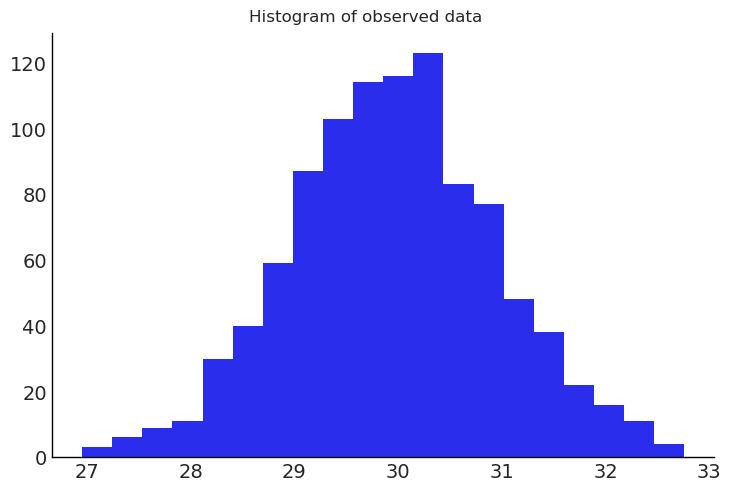

In [5]:
fig, ax = plt.subplots()
ax.hist(data, bins=20)
fig.suptitle("Histogram of observed data");


<span style="color:#85144b">As humans we can intuit *data mean* of **30** + an offset of **20** will lead to a parameter mean for *mu* of **10**. We want to see if our inference algorithm can recover our parameters.<span style="color:white">

## Single Variable Single Chain Inference Run

The simplest MCMC run we can perform is with a single variable and a single chain. We'll do so by putting our sampler function and data to use.


In [6]:
samples = 200
chain = mh_sampler(data=data, samples=samples)
chain[:100]

chain_le = mh_sampler(data=data, samples=samples, proposal=lambda x: stats.norm(x, 0.05).rvs())

# What would happen if we use wildly varying moves
# chain_exp = mh_sampler(data=data, samples=samples, proposal=lambda x: stats.norm(x, 5).rvs())


And just like that we've performed an inference run! We can generate a traceplot

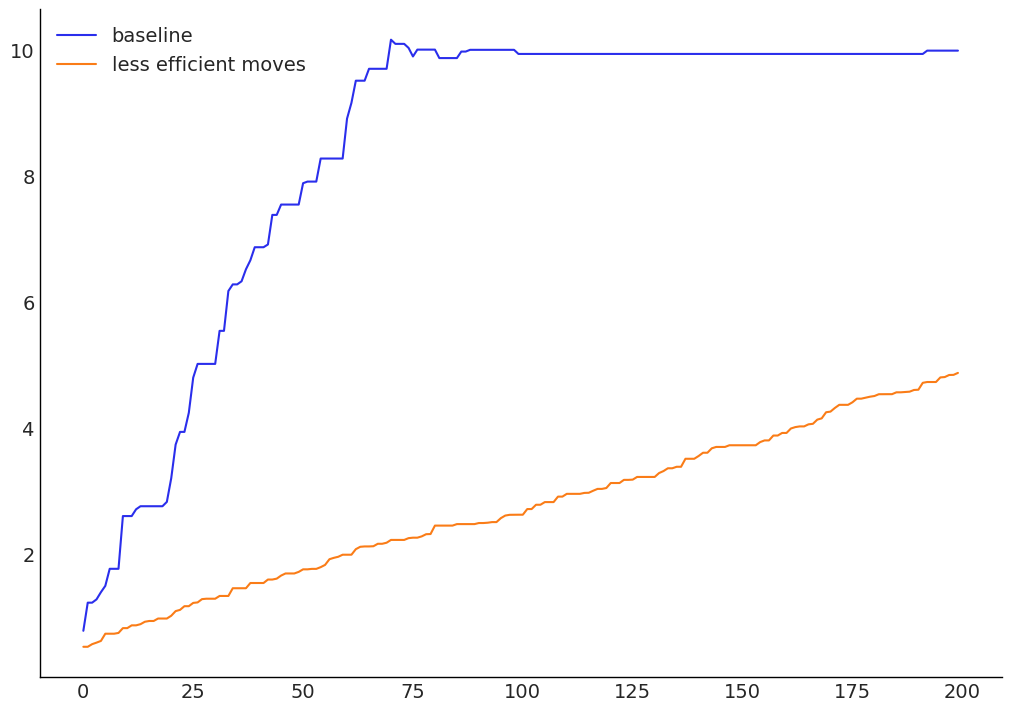

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
x = np.arange(samples)
ax.plot(x, chain, label="baseline");
ax.plot(x, chain_le, label="less efficient moves");
# ax.plot(x, chain_exp, label="wildly varying moves");
ax.legend()

**Note:** In terms of data structures, for a **single** variable **single** chain inference run, an array suffices for storing samples.

## Single Variable Multiple Chain Inference Run

As Bayesian modelers, life would be relatively easy if a single chain worked well every time, but unfortunately this is not the case. To understand why look at the above inference run. While the sampler started at *mu=8*, it took a 50 or so steps before the sampler honed in on the "correct" value of 10.

MCMC algorithms are sensitive to their starting points and in finite runs it's **not** guaranteed that the Markov Chain will approach the true underlying distribution. A common method to get around this is to sample from many chains in parallel and see if we get to the same place. We will discuss this further when we get to single model diagnostics.

In [8]:
chain_0 = mh_sampler(data=data, samples=samples)
chain_1 = mh_sampler(data=data, samples=samples, mu_init=13)
data_df = pd.DataFrame({"x_0":chain_0, "x_1":chain_1})

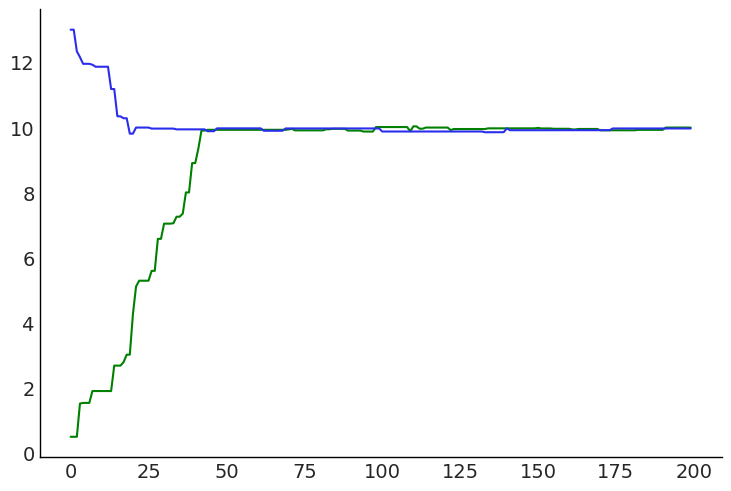

In [9]:
fig, ax = plt.subplots()
x = np.arange(samples)
ax.plot(x, data_df["x_0"], c="g")
ax.plot(x, data_df["x_1"])

**Note**: With two chains converging to approximately a single value we can be more confident that the sampler reached the true underlying parameter. We can also store the results in a 2D data structures, such as Pandas Dataframes in Python memory, and CSV or SQL tables for persistent on disk storage.


<div class="alert alert-block alert-danger">
This concludes today's DEMO. Below are supplementary sections copied from the original tutorial, whose goal is to introduce how MCMC results are stored. 
    
Note that we have updated the pystan code from version 2 to 3. The main idea is that the library [ArviZ](https://python.arviz.org/en/stable/) accepts inference result data from Stan, NetCDF, or custom-defined objects. And these data is stored in an [xarray](https://docs.xarray.dev/en/stable/) object.
</div>

## Multiple Variable Multiple Chain Inference Runs

A Bayesian modelers, life would be relatively easy if all models only had one variable (univariate models in math speak). Unfortunately many types of models require 2 or more variables. For example in a linear regression we are interested in estimating both <b>m</b> and <b>b</b>:

$$ y \sim mx+b$$

With at least 3 things to track (chains, samples, and variables) a 2d data structures become limiting. This problem exists in many domains and is the focus of the *xarray* project.

A motivating example comes from climate sciences. In this image from the xarray documentation the researcher might want to measure the temperature and humidity, across a 2D region at a point in time. Or they may want to plot the temperature over a time interval. xarray simplifies the data handling in cases like these.

![XarrayStructure](./img/dataset-diagram.png)



In [10]:
# we can use an xarray object to store MCMC output.
posterior = xr.Dataset(
        {"mu": (["chain", "draw"], [[11,12,13],[22,23,24]]), "sd": (["chain", "draw"], [[33,34,35],[44,45,46]])},
        coords={"draw": [1,2,3], "chain": [0,1]},
    )
posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 3)
Coordinates:
  * draw     (draw) int64 1 2 3
  * chain    (chain) int64 0 1
Data variables:
    mu       (chain, draw) int64 11 12 13 22 23 24
    sd       (chain, draw) int64 33 34 35 44 45 46

## Multiple Variable Multiple Chain Inference runs and associated datasets

As a Bayesian modelers, life would be relatively easy if we were only concerned about posterior distributions. Looking back at the full end to end workflow, recall that there are other datasets, such as prior predictive samples, posterior predictive samples, among others. To aid the ArviZ user we present `az.InferenceData`.

### az.InferenceData

az.InferenceData serves as a data container for the various xarray datasets that are generated from an end-to-end Bayesian workflow. Consider our earlier simple model, and this time let's use `stan` to run a full analysis with multiple chains, multiple runs, and generate all sorts of datasets common in Bayesian analysis.

In [11]:
stan_code_prior = """
data {
    int<lower=1> N;
}
parameters {
    real mu; // Estimated parameter
}
model {
    mu ~ normal(0, 1);
}
generated quantities {
    real y_hat[N]; // prior prediction
    for (n in 1:N) {
        y_hat[n] = normal_rng(mu+20, 1);
    }
}
"""
stan_data_prior = {"N" : len(data)}

stan_prior = stan.build(stan_code_prior, data=stan_data_prior, random_seed=1)
stan_fit_prior = stan_prior.sample()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_gy9vos60/model_z67j3ds2.stan', line 12, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would

In [12]:
stan_code_posterior = """
data {
    int N;
    real y[N]; // Observed data
}
parameters {
    real mu; // Estimated parameter
}
model {
    mu ~ normal(0, 1);
    y  ~ normal(mu+20, 1);
}
generated quantities {
    real y_hat[N]; // posterior prediction
    real log_lik[N]; // log_likelihood
    
    for (n in 1:N) {
        // Stan normal functions https://mc-stan.org/docs/2_19/functions-reference/normal-distribution.html
        y_hat[n] = normal_rng(mu, 1);
        log_lik[n] = normal_lpdf(y[n] | mu, 1);
    }
}
"""

stan_data_posterior = dict(
    y=data,
    N=len(data)
)

stan_model_posterior = stan.build(stan_code_posterior, data=stan_data_posterior, random_seed=1)
stan_fit_posterior = stan_model_posterior.sample()


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_1ofzo10_/model_57t6qsmr.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_1ofzo10_/model_57t6qsmr.stan', line 14, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_1ofzo10_/model_57t6qsmr.stan', line 15, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-form

In [13]:
# ArviZ reads MCMC result data from stan
stan_inference_data = az.from_pystan(posterior=stan_fit_posterior,
                       observed_data="y",
                       
                       # Other Bayesian Datasets that we have not discussed yet!
                       posterior_predictive="y_hat", 
                       prior=stan_fit_prior, 
                       prior_predictive="y_hat",
                       log_likelihood="log_lik",
                      )
stan_inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior

### NetCDF
Calculating the various datasets is usually not trivial. Network Common Data Form (NetCDF) is an open standard for storing multidimensional datasets, and `xarray` is a library for doing high performance analysis on those datasets. NetCDF even comes with "group" support, making it easy to serialize az.InferenceData straight to disk. ArviZ uses NetCDF to save the results to disk, allowing reproducible analyses, multiple experiments, and sharing with others.
 
ArviZ even ships with sample datasets, serialized in NetCDF
https://github.com/arviz-devs/arviz/tree/master/arviz/data/_datasets

In short: like SQL is to Pandas DataFrame, NetCDF is to az.InferenceData.

In [14]:
data = az.load_arviz_data("centered_eight")
data


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## The benefits of az.InferenceData
One of the goals for the ArviZ developers is to ensure that Bayesian practioners can share and reproduce analyses regardless of PPl, regardless of language and az.InferenceData was the implementation of this idea.

In summary az.InferenceData 

* provides a consistent format for Bayesian datasets.
* makes it easy to save results
* makes use of ArviZ plotting and statistics functions simpler
* stores metadata for ease of reproducibility

## InferenceData in practice

In practice it's rare to ever generate a xarray manually for use in ArviZ. Instead ArviZ provides methods for instantiating InferenceData from plain Python objects, mappings to various PPLs, as well as methods to save and load NetCDF files.

For further references consider the ArviZ cookbook, and data structure tutorial.
https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html
https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html

## Examples

See below for some useful methods of interacting with az.InferenceData, Xarray, and NetCDF

For Xarray methods we only demo a subset of the available API. For a much more comprehensive explanation view the indexing and selection page from the xarray docs
http://xarray.pydata.org/en/stable/indexing.html

### Creating InferenceData objects
We can create an InferenceData objects from our "home built" chain, not just from the output of supported PPLs

In [15]:
data_dict = {"mu": [chain_0, chain_1]}
home_built_data = az.from_dict(data_dict)
home_built_data

Inference data with groups:
	> posterior

In [16]:
# Load NetCDF from disk into memory
## Replace with NetCDF that's "visible"
data = az.load_arviz_data("centered_eight")

In [17]:
# Reference posterior directly
posterior = data.posterior
posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) object 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 ...
    theta    (chain, draw, school) float64 ...
    tau      (chain, draw) float64 ...
Attributes:
    created_at:                 2022-10-13T14:37:37.315398
    arviz_version:              0.13.0.dev0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              7.480114936828613
    tuning_steps:               1000

In [18]:
# Select specific variables
posterior[["mu", "tau"]]

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    mu       (chain, draw) float64 ...
    tau      (chain, draw) float64 ...
Attributes:
    created_at:                 2022-10-13T14:37:37.315398
    arviz_version:              0.13.0.dev0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              7.480114936828613
    tuning_steps:               1000

In [19]:
# Select specific chains and draws
posterior.sel(chain=[0,2], draw=slice(0,5))

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 6, school: 8)
Coordinates:
  * chain    (chain) int64 0 2
  * draw     (draw) int64 0 1 2 3 4 5
  * school   (school) object 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 ...
    theta    (chain, draw, school) float64 ...
    tau      (chain, draw) float64 ...
Attributes:
    created_at:                 2022-10-13T14:37:37.315398
    arviz_version:              0.13.0.dev0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              7.480114936828613
    tuning_steps:               1000

In [20]:
# Get first 10 samples of mu from chain 0
posterior["mu"].sel(chain=0, draw=slice(0,10)).values

array([ 7.87179637,  3.38455431,  9.10047569,  7.30429262,  9.87967529,
        7.04203187, 10.37846908, 10.06001612, 10.42530833, 10.81078156,
       10.85289768])

## Extra Credit
* xarray supports numpy "ufuncs" (https://docs.scipy.org/doc/numpy/reference/ufuncs.html). ArviZ uses these under the hood for efficient calculations. 